#PyTorch Powered MNIST GAN
This notebook is a small scale experiment building a generative adversarial network to create hand written digits. The network is trained on the MNIST dataset, one of the most common handwritten numerical datasets in the machine learning community.

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
bs = 100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))]) # One channel as grayscale images instead of 3 channel RGB

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [32]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [33]:
# build network
z_dim = 100
mnist_dim = train_dataset.data.size(1) * train_dataset.data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

print(G, D)

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
) Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)


In [34]:
# loss
criterion = nn.BCELoss()

# optimizer
lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [35]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()

In [36]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()

In [37]:
n_epoch = 200
for epoch in range(1, n_epoch+1):
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/200]: loss_d: 1.090, loss_g: 2.087
[2/200]: loss_d: 1.224, loss_g: 1.340
[3/200]: loss_d: 1.326, loss_g: 1.138
[4/200]: loss_d: 1.003, loss_g: 1.577
[5/200]: loss_d: 0.747, loss_g: 2.250
[6/200]: loss_d: 0.598, loss_g: 2.302
[7/200]: loss_d: 0.631, loss_g: 2.295
[8/200]: loss_d: 0.560, loss_g: 2.560
[9/200]: loss_d: 0.629, loss_g: 2.561
[10/200]: loss_d: 0.659, loss_g: 2.229
[11/200]: loss_d: 0.702, loss_g: 2.156
[12/200]: loss_d: 0.729, loss_g: 2.046
[13/200]: loss_d: 0.812, loss_g: 1.893
[14/200]: loss_d: 0.737, loss_g: 2.046
[15/200]: loss_d: 0.768, loss_g: 1.965
[16/200]: loss_d: 0.784, loss_g: 1.957
[17/200]: loss_d: 0.845, loss_g: 1.811
[18/200]: loss_d: 0.838, loss_g: 1.775
[19/200]: loss_d: 0.835, loss_g: 1.791
[20/200]: loss_d: 0.828, loss_g: 1.787
[21/200]: loss_d: 0.924, loss_g: 1.560
[22/200]: loss_d: 0.938, loss_g: 1.541
[23/200]: loss_d: 0.916, loss_g: 1.583
[24/200]: loss_d: 0.963, loss_g: 1.480
[25/200]: loss_d: 0.964, loss_g: 1.476
[26/200]: loss_d: 0.952, loss_g: 1

In [42]:
with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)

    save_image(generated.view(generated.size(0), 1, 28, 28), 'output_sample.png')

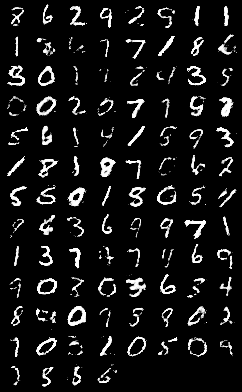

In [43]:
from IPython.display import Image
Image('output_sample.png')

Sources:
* [Generative Adversarial Networks](https://arxiv.org/pdf/1406.2661)
* [Deep Generative Models, Stanford CS236](https://www.youtube.com/playlist?list=PLoROMvodv4rPOWA-omMM6STXaWW4FvJT8)
* [MNIST GAN & DCGAN](https://github.com/znxlwm/pytorch-MNIST-CelebA-GAN-DCGAN)
* [MNIST GAN 1](https://github.com/prcastro/pytorch-gan/blob/master/MNIST%20GAN.ipynb)
* [MNIST GAN 2](https://github.com/lyeoni/pytorch-mnist-GAN/blob/master/pytorch-mnist-GAN.ipynb)